In [9]:
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install zstandard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.9 MB/s eta 0:00:00


In [10]:
import torch
import copy
from torch.utils.data import DataLoader
import json
from datasets import load_dataset
from evaluate import load as load_metric
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.optimization import AdamW
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
import time
import os
import sys
import pickle
from common_code import *

In [11]:
# Hyperparameters
epochs = 1 # epochs to train (unless validation loss rises)
bs = 1
learn = 5e-5
early_stop_patience = 1 # >= 1 (if val loss increases, runs early_stop_patience more epochs, then stops)
mod_size = "70m"
N=12

model_title = f"pythia-{mod_size}-deduped"
model_name = "EleutherAI/" + model_title
model_revision = "step143000"
model_cache_dir = "./"+ model_title +"/"+model_revision

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  revision=model_revision,
  cache_dir=model_cache_dir,
)

In [12]:
dataset = list(dict.fromkeys(entry["text"] for entry in load_dataset("the_pile_val.py", split="validation").shuffle(seed=229)))
dataset = dataset[:len(dataset)//40]
train_dataset = dataset[:len(dataset)//2]
val_dataset = dataset[len(dataset)//2:]
print(len(train_dataset))

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset the_pile_val downloaded and prepared to /root/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30. Subsequent calls will reuse this data.
2678


# Utility Methods

In [13]:
## Collate functions for loading dataset
def collate_fn(batch):
    tokens = [tokenizer.encode(example, return_tensors="pt", truncation=True,max_length=model.config.max_position_embeddings) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return {
        "input_ids":tokens_padded,
        "labels":tokens_padded,
        "attention_mask": torch.tensor(tokens_padded>0,dtype=int)
    }
def train(model, train_dataset, val_dataset, collate_fn, batch_size, epochs):
    model.config.use_cache = False
    training_args = TrainingArguments(output_dir="fine-tuning",
                                        do_train=True,
                                        do_eval=True,
                                        num_train_epochs=epochs,
                                        per_device_train_batch_size=batch_size,
                                        per_device_eval_batch_size=batch_size,
                                        evaluation_strategy="epoch",
                                        logging_strategy="epoch",
                                        save_strategy="epoch",
                                        gradient_accumulation_steps=1,
                                        gradient_checkpointing=False,
                                        load_best_model_at_end = True,
                                        optim="adafactor",
                                        )
    trainer = Trainer(model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=tokenizer,
                    data_collator=collate_fn,
                    callbacks=[EarlyStoppingCallback(early_stop_patience, 0.0)] # if val loss improve for >1 iterations, end. 
                    )
    trainer.train()
    return model

# Base Model

In [14]:
model = GPTNeoXForCausalLM.from_pretrained(
  model_name,
  revision=model_revision,
  cache_dir=model_cache_dir,
)

tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  revision=model_revision,
  cache_dir=model_cache_dir,
)

train(model, train_dataset, val_dataset, collate_fn, bs, epochs)
model.save_pretrained(f"lira_new/pythia-{mod_size}-base", from_pt=True) 
del model
torch.cuda.empty_cache()

<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.839800,3.449815


In [17]:
data_chunks = [dataset[i * len(dataset)//N : (i+1) * len(dataset) // N] for i in range(N)]

In [18]:
def arr_split(chunks, N):
    if N % 2 != 0:
        print("Need even N!")
        return []
    lists = [[] for i in range(N)]

    for i in range(N):
        for j in range(i, int(i + N/2)):
            lists[i] += chunks[j % N]

    return lists
  
def orthogonal_chunk(i):
    return int(N/2 + i) % N

In [19]:
data_arr = arr_split(data_chunks, N)

In [20]:
print(len(data_arr[0]))

2678


In [21]:
print(len(train_dataset))

2678


# Train Shadow Models

In [22]:
for i in range(N):
  mem_stats()
  print(f"Model #{i}")
  model = GPTNeoXForCausalLM.from_pretrained(
    model_name,
    revision=model_revision,
    cache_dir=model_cache_dir,
  ).to(device)
  train(model, data_arr[i], data_arr[orthogonal_chunk(i)], collate_fn, bs, epochs)
  model.save_pretrained(f"lira_new/pythia-{mod_size}-shadow-{i}", from_pt=True) 
  del model
  torch.cuda.empty_cache()
  mem_stats()

Total Memory: 39.56 GB
Reserved Memory: 0.34 GB (0.86%)
Remaining Memory: 39.22 GB (99.14%)
---------------------------------
Allocated Memory: 0.30 GB (0.77%)
Percent of Reserved Allocated: 89.63%

Model #0


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.839800,3.449815


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #1


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.836000,3.425721


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #2


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.839100,3.429059


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #3


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.862700,3.422980


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #4


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.872700,nan


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #5


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.874900,nan


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #6


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.875000,nan


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #7


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.860700,nan


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #8


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.841400,nan


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #9


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.835900,nan


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #10


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.821600,3.428258


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%

Model #11


<ipython-input-13-72a79dc70efa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss
1,3.822500,3.438773


Total Memory: 39.56 GB
Reserved Memory: 0.32 GB (0.81%)
Remaining Memory: 39.24 GB (99.19%)
---------------------------------
Allocated Memory: 0.31 GB (0.77%)
Percent of Reserved Allocated: 95.32%



# Inference

In [23]:
def get_in_models(chunk_no, N):
    """
    Returns a list of models that should be used for inference for a given chunk
    """
    ins = []
    outs = []
    for i in range(N):
        lower = i
        upper = int(i+N/2)
        innit = False
        for j in range(lower, upper):
            if chunk_no == j % N:
                innit = True
        if innit:
            ins.append(i)
        else:
            outs.append(i)
    return (ins, outs)

In [24]:
from torch.nn import CrossEntropyLoss
import math

def compute_ce_loss(model, tokenizer, string):
    # input_ids = tokenizer.encode(string, return_tensors="pt").to(device)
    input_ids = tokenizer.encode(string, return_tensors="pt", truncation=True,max_length=model.config.max_position_embeddings).to(device) 

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    loss_fn = CrossEntropyLoss()
    input_len = input_ids.shape[-1] - 1
    input_ids_without_first_token = input_ids[:, 1:]
    logits_without_last_token = logits[:, :-1, :]
    loss = loss_fn(logits_without_last_token.view(-1, logits.size(-1)), input_ids_without_first_token.view(-1))
    return loss

def compute_confidence(ce_loss):
    conf = math.exp(-1 * ce_loss)
    return math.log(conf / (1-conf))

In [25]:
def chunks_this_model(mid):
  # Get chunks w/ this model ID
  inc = []
  outc = []
  for i in range(mid, mid+6):
    inc.append((i) % 12)
  for i in range(N):
    if i not in inc:
      outc.append(i)
  return (inc, outc)

In [ ]:
# Briefly, this is what this method does:
# Because it's too time consuming to load models in and out of memory, and not enough RAM to keep all of them there, it loads in one model at a time, does all evaluations
# for that model, and continues. 
# initializes an array for every data point that contains an array of confidences for IN, OUT, and then target CONF. Only compute target CONF when that example has never been seen before. 

# Load a model into GPU RAM
example_data = [[] for i in range(len(data_chunks))]
all_arr = [f"./lira_new/pythia-70m-shadow-{i}" for i in range(N)]
target_model = GPTNeoXForCausalLM.from_pretrained(f"./lira_new/pythia-70m-base").to(device)

# Run all points on it
for i, path in enumerate(all_arr):
  print(f"Loading {i} / {path}")
  t_model = GPTNeoXForCausalLM.from_pretrained(path).to(device)
  # Get chunks
  inc, outc = chunks_this_model(i)

  for c in inc:
    print(f" - inc {c}")
    if len(example_data[c]) == 0:
      for example in data_chunks[c]:
        # IN MODEL
        ce_loss = compute_ce_loss(t_model, tokenizer, example)
        conf = compute_confidence(ce_loss)

        # TARGET
        target_ce_loss = compute_ce_loss(target_model, tokenizer, example)
        targ_conf = compute_confidence(target_ce_loss)
        example_data[c].append([[conf], [], targ_conf])
        # print(f"{conf} / {targ_conf}")
    else:
      for i, example in enumerate(data_chunks[c]):
        # IN MODEL
        ce_loss = compute_ce_loss(t_model, tokenizer, example)
        conf = compute_confidence(ce_loss)
        example_data[c][i][0].append(conf)
  
  for c in outc:
    print(f" - outc {c}")
    if len(example_data[c]) == 0:
      for example in data_chunks[c]:
        # OUT MODEL
        ce_loss = compute_ce_loss(t_model, tokenizer, example)
        conf = compute_confidence(ce_loss)

        # TARGET
        target_ce_loss = compute_ce_loss(target_model, tokenizer, example)
        targ_conf = compute_confidence(target_ce_loss)
        example_data[c].append([[], [conf], targ_conf])
        # print(f"{conf} / {targ_conf}")
    else:
      for i, example in enumerate(data_chunks[c]):
        # OUT MODEL
        ce_loss = compute_ce_loss(t_model, tokenizer, example)
        conf = compute_confidence(ce_loss)
        example_data[c][i][1].append(conf)

  del t_model
  torch.cuda.empty_cache()

In [ ]:
from scipy import stats

results = []

for c_num, c in enumerate(example_data):
  for e, i in enumerate(c):
    mu_target = i[2]
    mu_in = np.mean(i[0])
    std_in = np.std(i[0])
    mu_out = np.mean(i[1])
    std_out = np.std(i[1])
    
    likelihood_in = stats.norm.pdf(mu_target, mu_in, std_in)
    likelihood_out = stats.norm.pdf(mu_target, mu_out, std_out)
    lira = likelihood_in / likelihood_out

    # There can be a tiny few LiRa's so high they go out of fp64 precision. Catch them here. 
    if np.isnan(lira) or np.isinf(lira):
      print("Nan")
      continue

    in_true_model = c_num >= 0 and c_num < N/2
    results.append((likelihood_in,likelihood_out,lira,in_true_model))

    
    if e % 20 == 0:
      print(f"Numbers: {i} \nMuIn:{mu_in} / StdIn:{std_in}\nMuOut:{mu_out} / Std_Out:{std_out}\nLR:{lira}\nIn True Model? {in_true_model}\n ------- \n")

with open("./lira_new/lira.pickle","wb") as f:
    pickle.dump(results,f)

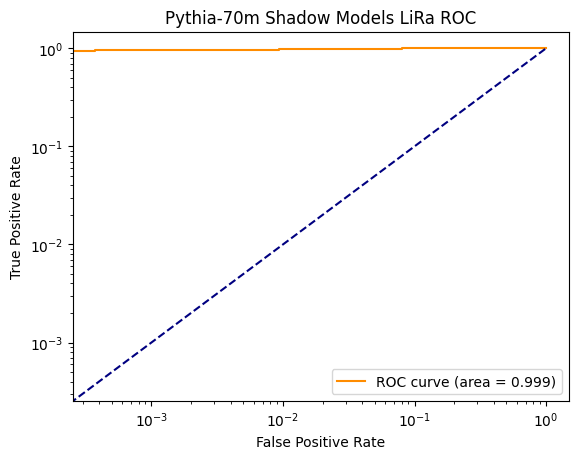

In [37]:
with open("./lira_new/lira.pickle","rb") as f:
    results = pickle.load(f)
# Generate ROC curve 
fpr, tpr, thresholds = roc_curve([int(result[3]) for result in results], [result[2] for result in results])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.loglog(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Shadow Models LiRa ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

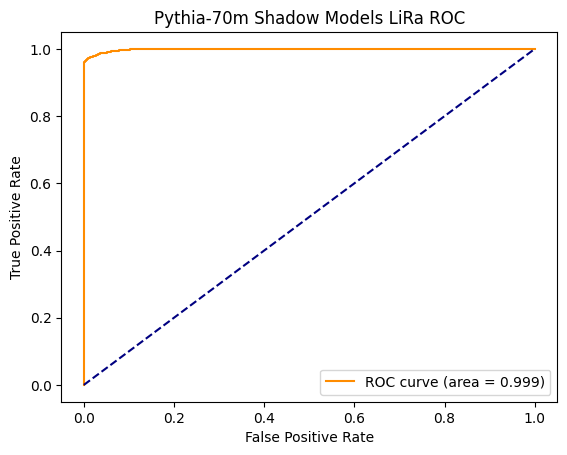

In [39]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title(f"Pythia-{mod_size} Shadow Models LiRa ROC")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()